# Machine Learning Assignment 2
Jeremiah Pratt
Due 10/11/17

In [1]:


#Note from professor Curro: WRITE YA SHAPES OUT

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
import seaborn as sns
from itertools import chain
from random import shuffle
from numpy.core.umath_tests import inner1d

In [2]:
def conjugates(mu, cov, x, y):
    
    #Fixing shapes
    x = np.atleast_2d(x)                           #matmul doesn't like scalars
    y = np.atleast_2d(y).transpose()
    phi = np.concatenate([np.ones_like(x), x],axis=0)     #Makes a vector of [1,x]'s 

    
    #Covariance Update Equation
    newCov = np.linalg.inv(np.linalg.inv(cov) 
                           + Beta*np.matmul(phi,phi.transpose()))  
    
    #Mean Update Equation
    newMu = np.matmul(newCov, np.matmul(np.linalg.inv(cov), mu) 
                      + Beta*np.matmul(phi, y))
   
    return newMu, newCov

In [3]:
def calcLikelihood(x,y, ax):
    
    
    #3D plotting coordinates
    XG, YG = np.meshgrid(np.arange(-1,1,.01),
                         np.arange(-1,1,.01))
    
    #Likelihood equation
    L = np.sqrt(Beta/(2*np.pi)) * np.exp((-Beta/2)*(x-XG - YG*y)**2)
    
    #heatmap creation
    sns.heatmap(np.flipud(L),cmap='rainbow',cbar = False, xticklabels = False,
               yticklabels = False, ax = ax)
    
    ax.set_xlabel('w0')
    ax.set_ylabel('w1')
    
    return ax

In [4]:
def calcPosterior(Mu,cov,ax):
    
    #reshaping stuff
    Mu =  Mu.ravel()
    Mu = Mu.tolist()
    cov = cov.tolist()
    
    #different graphing documentation taken from scipy documentation for multi
    #variate normal
    X, Y = np.mgrid[-1:1:.01, -1:1:.01]
    pos = np.empty(X.shape + (2,))
    pos[:, :, 0] = X; pos[:, :, 1] = Y
    rv = multivariate_normal(Mu,cov)
    ax.contourf(X, Y, rv.pdf(pos), cmap='rainbow')
    ax.set_xlabel('w0')
    ax.set_ylabel('w1')
    ax.set_xlim(-1,1)
    ax.set_ylim(-1,1)
    
    #plotting "truth"
    ax.scatter(a0,a1, marker = 'x', color = 'white')
    
    return ax

In [5]:
def plotSamples(Mu, cov, x = None, y = None, ax = None):
    
    #pulls 6 samples from posterior distribuution for plotting
    w = np.random.multivariate_normal(Mu.ravel(), cov, 6)
    
    #literally just x
    xPlot = np.linspace(-1,1)
    
    #generate lines from 6 samples
    for i in range(6):
        yPlot = w[i,0] + (w[i,1] * xPlot)
        ax.plot(xPlot,yPlot)
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.set_xlim(-1,1)
        ax.set_ylim(-1,1)
        
    #plotting points observed so far
    if x is not None and y is not None:
        ax.scatter(x,y)



In [6]:
#Generating uniform distribution of samples of X, 

a0 = -0.3
a1 = 0.5
Beta = 25

#all given in book
mu0 = np.array([[0], [0]])
cov0 = np.array([(2,0),(0,2)])

#generate noisy line
x = np.random.uniform(-1,1,20)
y = x*a1 + a0 + np.random.normal(0,.2,20)

#learning from observations using update eqns
mu1, cov1 = conjugates(mu0, cov0, x[0], y[0])
mu2, cov2 = conjugates(mu1, cov1, x[1], y[1])
mu20, cov20 = conjugates(mu2, cov2, x[2:], y[2:] )

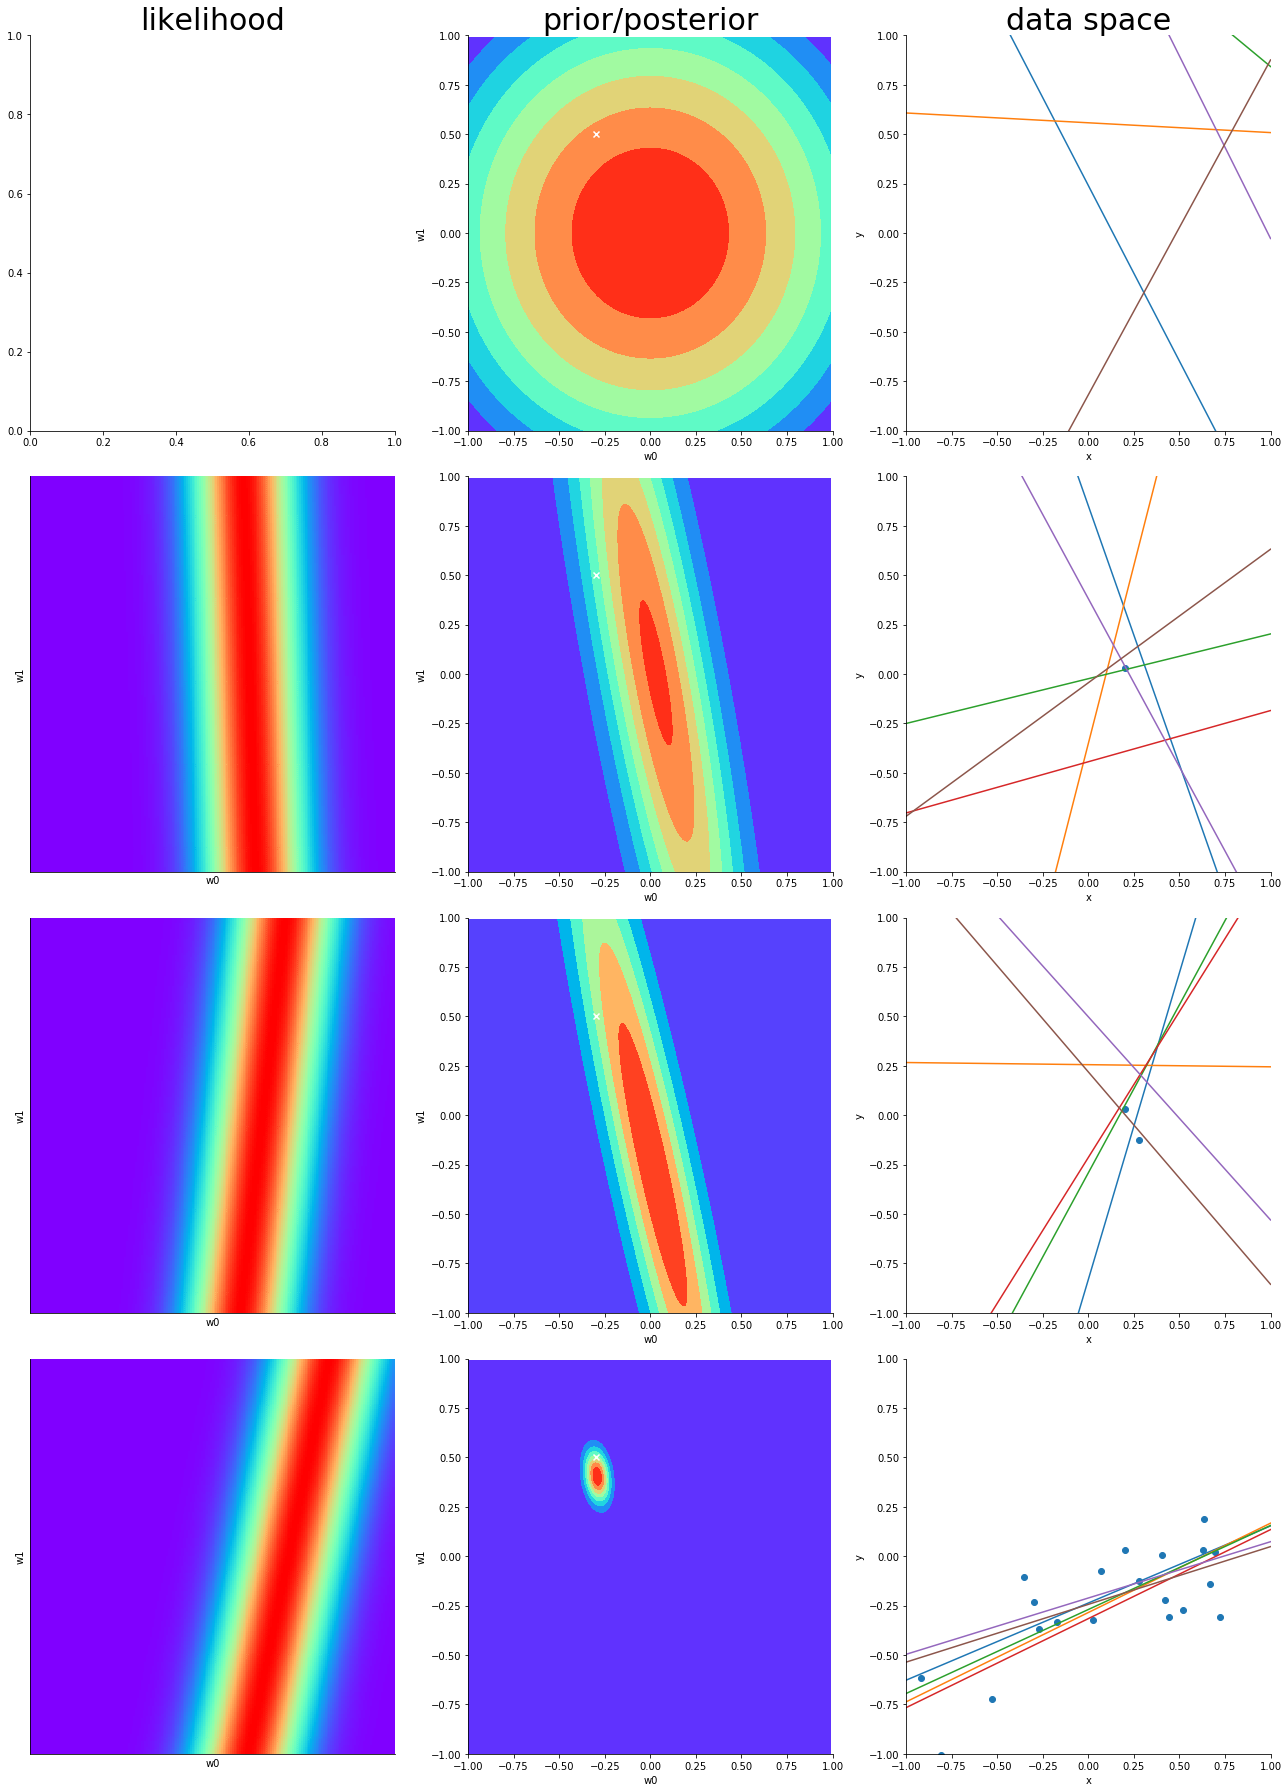

In [7]:
#Using Conjugate Priors to find values for w0 and w1
#Multivariate Normal Distribution with KNOWN precision

figure, axr = plt.subplots(nrows=4, ncols=3, figsize=[18,25])

calcPosterior(mu0,cov0, axr[0,1])
plotSamples(mu0,cov0, ax=axr[0,2])

calcLikelihood(x[0],y[0], axr[1,0])
calcPosterior(mu1,cov1, axr[1,1])
plotSamples(mu1,cov1,x[0],y[0], axr[1,2])

calcLikelihood(x[1],y[1],axr[2,0])
calcPosterior(mu2,cov2,axr[2,1])
plotSamples(mu2,cov1,x[:2],y[:2], axr[2,2])

calcLikelihood(x[19],y[19],axr[3,0])
calcPosterior(mu20,cov20,axr[3,1])
plotSamples(mu20,cov20,x,y,axr[3,2])

axr[0,0].set_title('likelihood',fontsize = 30)
axr[0,1].set_title('prior/posterior',fontsize = 30)
axr[0,2].set_title('data space', fontsize = 30)

plt.tight_layout()
sns.despine(figure)
plt.show()


# Predictive Distribution

In [8]:
#9 Gaussian basis functions, spaced equally from 0 to 1
gauss_means = np.linspace(0,1,9)

#STDEVS for Gaussian bases (assumed)
gauss_stdev = 0.3

In [9]:
def gauss_update(mu, stdev, x, y):
    
    #Fixing shapes
    if type(x) == np.float64:
        d = np.zeros((1,9))
    else:
        d = np.zeros((len(x), 9))
        
    if type(y) == np.ndarray:
        y = np.reshape(y, (len(y), 1))
    
    #creating design matrix for 9 basis functions (eq 3.4)
    for i in range(d.shape[1]):
        d[:,i] = np.exp(-(x - gauss_means[i]) ** 2
                       / (2*(gauss_stdev) ** 2))

    #Standard Deviation Update Equation
    newStdev = np.linalg.inv(np.linalg.inv(stdev) 
                           + Beta*np.dot(d.transpose(),d))  
    

    #Mean Update Equation
    newMu = np.dot(newStdev, np.dot(np.linalg.inv(stdev), mu) 
                      + Beta*np.dot(np.transpose(d),y))
   
    return newMu, newStdev

In [10]:
def plot_predictions(m, stdev, ax):
    
    
    #uses observations to create a design matrix for your basis functions.
    #the effect here is that the design matrix will have larger values
    #corresponding to gaussians closer to the observation
    #x = np.atleast_2d(x)
    #d = np.zeros((len(x),9))
    
    x = np.linspace(0,1)
    d = np.zeros((len(x), 9))
    
    #setting up design matrix again
    for i in range(d.shape[1]):
        d[:,i] = np.exp(-(x - gauss_means[i]) ** 2
                       / (2*(gauss_stdev) ** 2))
    
    
    #mean update
    prediction_mean = np.dot(d,m)
    prediction_mean = np.transpose(prediction_mean)
    
    #plotting predicted line
    ax.plot(x, prediction_mean.squeeze(), color = 'red')
    
    #stdev update
    stdevNew = np.sqrt(1/Beta + inner1d(np.dot(d,stdev), d))
    
    #plotting stdev
    high = prediction_mean + stdevNew
    low = prediction_mean - stdevNew
    
    ax.fill_between(x, high.squeeze(), low.squeeze(), facecolor = 'red', 
                    alpha = 0.1, interpolate = True)
    
    return ax

In [11]:
def truth(ax):
    #plotting the true function (duh)
    
    x = np.linspace(0,1)
    y = np.sin(2*np.pi*x)
    ax.plot(x,y, color = 'green')
    
    return ax

In [12]:
def plot_points(n,ax):
    #plotting our noisy data
    
    ax.scatter(x[:n],y[:n])
    
    return ax

In [13]:
#Data Generation

#given
Beta = 25
Alpha = 2

#generating noisy sin function
x = np.linspace(0,1, 25)
shuffle(x)
y = np.sin(2*np.pi*x) + np.random.normal(0, .2, 25)

#priors
m0 = np.zeros([9,1])
s0 = Alpha * np.identity(9)

#updating
m1, s1 = gauss_update(m0, s0, x[0], y[0])
m2, s2 = gauss_update(m1, s1, x[1], y[1])
m4, s4 = gauss_update(m2, s2, x[2:4], y[2:4])
m25, s25 = gauss_update(m4, s4, x[4:], y[4:])

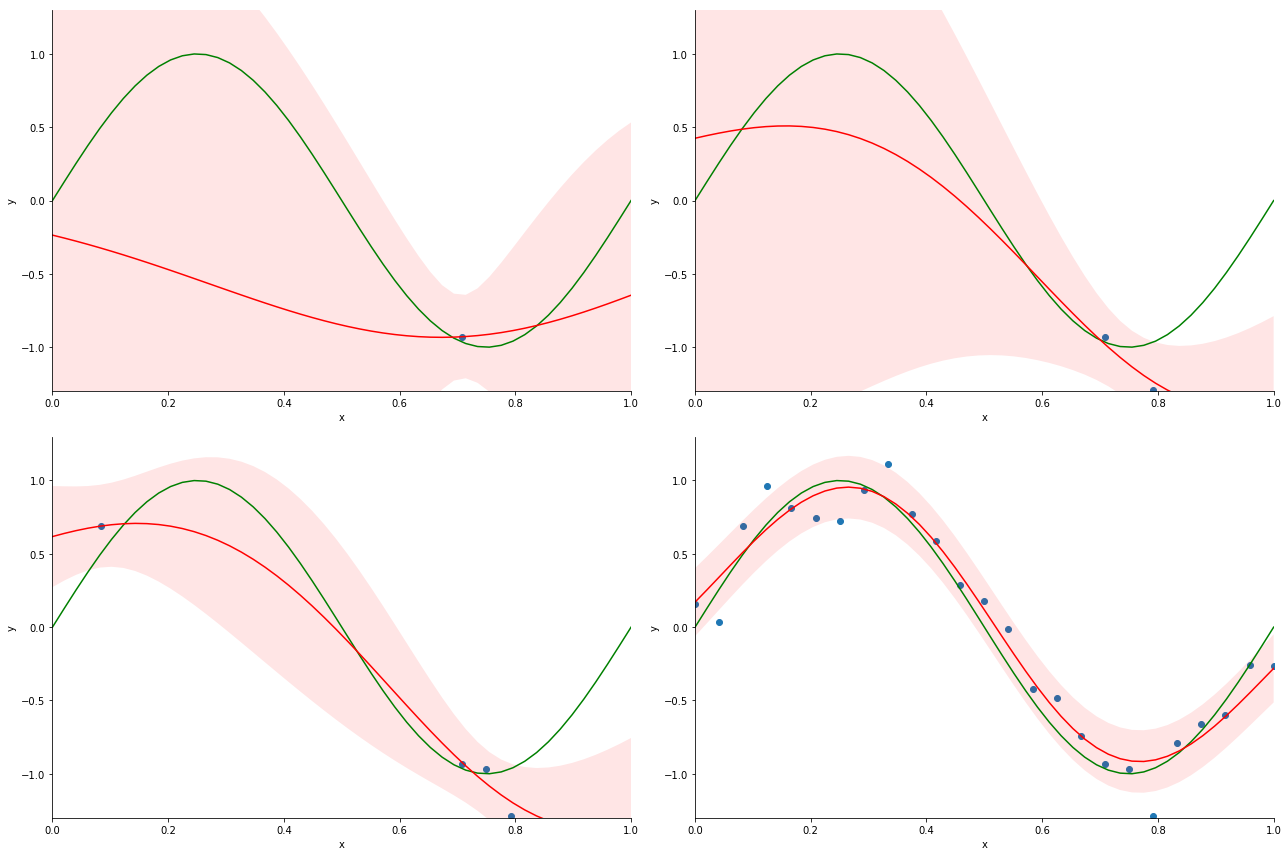

In [14]:
#Plotting
fix, axr = plt.subplots(nrows=2, ncols=2, figsize=[18,12])

truth(axr[0,0])
truth(axr[0,1])
truth(axr[1,0])
truth(axr[1,1])

plot_points(1, axr[0,0])
plot_points(2, axr[0,1])
plot_points(4, axr[1,0])
plot_points(25, axr[1,1])

plot_predictions(m1, s1, axr[0,0])
plot_predictions(m2, s2, axr[0,1])
plot_predictions(m4, s4, axr[1,0])
plot_predictions(m25, s25, axr[1,1])

for i in range(0,2):
    for j in range(0,2):
        axr[i,j].set_xlim([0,1])
        axr[i,j].set_ylim([-1.3, 1.3])
        axr[i,j].set_ylabel('y')
        axr[i,j].set_xlabel('x')


plt.tight_layout()
sns.despine()
plt.show()